# ChordGAN

ChordGAN importing the models from a py file

In [1]:
import pretty_midi
import reverse_pianoroll
import convert
import librosa

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
from datetime import datetime
from functools import reduce

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Concatenate
from keras.initializers import GlorotNormal
from keras.activations import sigmoid
from keras.losses import Loss

%load_ext lab_black
%load_ext tensorboard


# python script, in github repo
print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Numpy version:", np.__version__)

TF version: 2.6.0
Keras version: 2.6.0
Numpy version: 1.21.2


Use the following to avoid GPU errors (if needed)

In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

## Setup helper functions

In [3]:
n_timesteps = 4


def get_chroma(song, chroma_dims=12, n_notes=78):
    chroma = np.zeros(shape=(song.shape[0], chroma_dims))  # 12 chroma values
    for i in np.arange(song.shape[0]):
        for j in np.arange(n_notes):
            if song[i][j] > 0:
                chroma[i][np.mod(j, chroma_dims)] += 1
    return chroma


def reshape_step(input_, input_timesteps):
    input_ = input_[: input_timesteps * n_timesteps]  # discard any extra timesteps
    input_ = input_.reshape([input_timesteps, input_.shape[1] * n_timesteps])
    return input_


# add songs to data
def get_songs(path):
    files = glob.glob("{}/*.mid*".format(path))
    songs, fnames, chromas = [], [], []
    for f in files:
        try:
            data = pretty_midi.PrettyMIDI(f)
            song = data.get_piano_roll(fs=16)
            song = convert.forward(song)
            chroma = get_chroma(song)

            # Reshaping steps
            song_timesteps = song.shape[0] // n_timesteps
            song = reshape_step(song, song_timesteps)
            chroma = reshape_step(chroma, song_timesteps)

            songs.append(song)
            chromas.append(chroma)
            fnames.append(f)
        except Exception as e:
            raise e
    return songs, fnames, chromas


# custom function to extract chroma features from song
def get_chromas(songs, chroma_dims=12, n_notes=78):
    """
    chroma_dims : int
        The dimension of the chromas (12 notes in an equal tempered scale)
    n_notes : int
        The number of notes in the MIDI format
    """
    chromas = []
    for song in songs:
        chroma = np.zeros(shape=(song.shape[0], chroma_dims))  # 12 chroma values
        for i in np.arange(song.shape[0]):
            for j in np.arange(n_notes):
                if song[i][j] > 0:
                    chroma[i][np.mod(j, chroma_dims)] += 1
        # print(np.shape(chroma))
        # Reshaping steps
        chroma = reshape_step(chroma, trim=True)
        chromas.append(chroma)

    return chromas


def join_datasets(song_ds, chroma_ds, shuffle_buffer=10000):
    """I don't think I need batching here, but I can include it 
    if I use `tf.data.Dataset.bucket_by_sequence_length`.

    The map function expanding dims essentially creates a batch of size 1 so that 
    it fits the model inputs

    """
    return (
        tf.data.Dataset.zip((song_ds, chroma_ds))
        .shuffle(shuffle_buffer)
        .map(
            lambda song, chroma: (
                tf.expand_dims(song, axis=0),
                tf.expand_dims(chroma, axis=0),
            )
        )
    )

## Load data

In [4]:
fpath = "../data/chordGan/pop"
genre = fpath.split("/")[-1]

songs, fnames, chromas = get_songs(fpath)
# chromas = get_chromas(songs)
print("{} songs processed".format(len(songs)))

C:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


122 songs processed


In [5]:
from functools import reduce

dss = [tf.data.Dataset.from_tensors(s) for s in songs]
song_ds = reduce(lambda x, y: x.concatenate(y), dss)

dsc = [tf.data.Dataset.from_tensors(s) for s in chromas]
chroma_ds = reduce(lambda x, y: x.concatenate(y), dsc)

dataset = join_datasets(song_ds, chroma_ds)

for (s, c) in dataset.take(1):
    print(s.shape, c.shape)

(1, 36, 624) (1, 36, 48)


Let's peek at the chromas

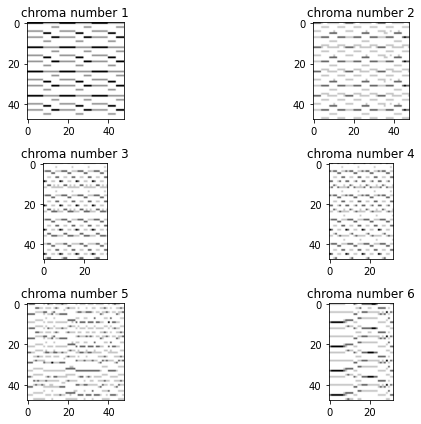

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, (chroma, ax) in enumerate(zip(chromas[:10], axes.flatten())):
    ax.set_title(f"chroma number {i+1}")
    ax.imshow(chroma[:48].T, cmap="Greys")
plt.tight_layout()
plt.show()

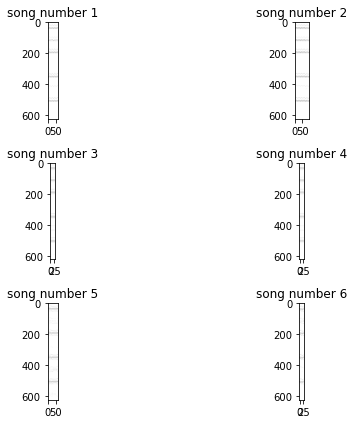

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, (song, ax) in enumerate(zip(songs[:10], axes.flatten())):
    ax.set_title(f"song number {i+1}")
    ax.imshow(song[:128].T, cmap="Greys")
plt.tight_layout()
plt.show()

TODO: Are the reshaped chromas/songs correct?

## Setup GAN model

Note:

The discriminator has both the song timeseries and the chromagram as inputs, hence the two-dimensional inputs!

In [8]:
from src.model import ChordGAN

low_note, high_note = 0, 78  # The index of lowest/highest note on the piano roll
note_range = high_note - low_note

n_timesteps = 4  # This is the number of timesteps that we will create at a time
X_dim = 2 * note_range * n_timesteps  # This is the size of the visible layer.
Z_dim = 12 * n_timesteps

cgan = ChordGAN(X_dim, Z_dim)
cgan.compile(tf.keras.optimizers.Adam(), tf.keras.optimizers.Adam())

Test the generator

(1, 64, 624)


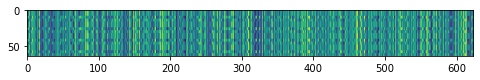

In [9]:
sample_chroma = chromas[0]
sample_out = cgan.generator(sample_chroma[tf.newaxis, ...])

print(sample_out.shape)
plt.figure(figsize=(8, 6))
plt.imshow(sample_out[0])
plt.show()

In [10]:
sample_out

<tf.Tensor: shape=(1, 64, 624), dtype=float32, numpy=
array([[[0.32327676, 0.41935948, 0.46725246, ..., 0.34950575,
         0.6210913 , 0.12948461],
        [0.32327676, 0.41935948, 0.46725246, ..., 0.34950575,
         0.6210913 , 0.12948461],
        [0.32327676, 0.41935948, 0.46725246, ..., 0.34950575,
         0.6210913 , 0.12948461],
        ...,
        [0.4977144 , 0.25775284, 0.28326178, ..., 0.25823474,
         0.5827417 , 0.32074118],
        [0.4977144 , 0.25775284, 0.28326178, ..., 0.25823474,
         0.5827417 , 0.32074118],
        [0.4977144 , 0.25775284, 0.28326178, ..., 0.25823474,
         0.5827417 , 0.32074118]]], dtype=float32)>

Test the discriminator

In [11]:
sample_song = songs[0]
print("shaped song shape:", sample_song.shape)

sample_logits, sample_probas = cgan.discriminator(
    [sample_song[tf.newaxis, :10], sample_chroma[tf.newaxis, :10]]
)
print(
    f"Probability this is a true song, not a generated song: {tf.reduce_mean(sample_probas).numpy():.2%} "
)

shaped song shape: (64, 624)
Probability this is a true song, not a generated song: 49.31% 


# Training

We define a training step that will propagate the gradients for both generator and discriminator

In [23]:
cgan.fit(dataset, batch_size=10, epochs=5)

Epoch 1/5
122/122 [==============================] - 2s 13ms/step - d_loss: 0.0058 - g_loss: 11.5816
Epoch 2/5
122/122 [==============================] - 1s 12ms/step - d_loss: 0.0039 - g_loss: 12.8740
Epoch 3/5
122/122 [==============================] - 2s 13ms/step - d_loss: 0.0030 - g_loss: 13.0630
Epoch 4/5
122/122 [==============================] - 2s 14ms/step - d_loss: 0.0071 - g_loss: 12.2497
Epoch 5/5
122/122 [==============================] - 2s 15ms/step - d_loss: 0.0451 - g_loss: 10.9752


We can access the losses via `history.history`

In [21]:
cgan.history.history

{'d_loss': [0.07020437717437744,
  0.14300507307052612,
  0.049192726612091064,
  0.014425333589315414,
  0.00011438341607572511],
 'g_loss': [7.6888427734375,
  8.731822967529297,
  6.896800994873047,
  9.049870491027832,
  15.197906494140625]}

#### TODO:
Now that i'm able to train the model, I need to implement the `call` method, that will convert the songs, if the model is trained.

In [ ]:
# Reshape song from song_timesteps x 2*note_range
# to n_timesteps x 2*note_range
# print("initial song shape", song.shape)
sample = songs[0]
print(sample.shape)
song_timesteps = sample.shape[0] // n_timesteps
sample = sample[: song_timesteps * n_timesteps]  # discard any extra timesteps
sample = sample.reshape([song_timesteps, sample.shape[1] * n_timesteps])
print(sample.shape)

(256, 156)
(64, 624)


In [ ]:
num_epochs = 500
batch_size = 10
logs_path = f"train_logs/base_chordgan/{genre}/"
writer = tf.summary.create_file_writer(logs_path)

print(f"Training for {num_epochs} epochs, each with {len(songs)} steps")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}", flush=True)
    for step, (song, chroma) in enumerate(zip(songs, chromas)):
        # Reshape song from song_timesteps x 2*note_range
        # to n_timesteps x 2*note_range
        # print("initial song shape", song.shape)
        song_timesteps = song.shape[0] // n_timesteps
        song = song[: song_timesteps * n_timesteps]  # discard any extra timesteps
        song = song.reshape([song_timesteps, song.shape[1] * n_timesteps])
        # print("  final song shape", song.shape)

        # Similar process for the chroma
        # print("initial chroma shape", chroma.shape)
        chroma = chroma[: song_timesteps * n_timesteps]
        chroma = chroma.reshape([song_timesteps, chroma.shape[1] * n_timesteps])
        # print("  final chroma shape", chroma.shape)

        # This is not really a batch size, it is actually splitting the songs
        # in timesteps of size `batch_size` and training the model on the
        # sequences
        for idx in range(0, len(song), batch_size):
            X = song[tf.newaxis, idx : idx + batch_size, ...]
            Z = chroma[tf.newaxis, idx : idx + batch_size, ...]
            # print(X.shape, Z.shape)
            loss_writer = writer if step == len(songs) - 1 else None
            train_step(X, Z, loss_writer=False, step=step)

        if step + 1 % 10 == 0:
            print(".", end="", flush=True)

Training for 500 epochs, each with 122 steps
Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Ep

In [ ]:
generator.save("trained_models/pop/generator/base_500e")
discriminator.save("trained_models/pop/discriminator/base_500e")

INFO:tensorflow:Assets written to: trained_models/pop/generator/base_500e\assets


INFO:tensorflow:Assets written to: trained_models/pop/generator/base_500e\assets


In [ ]:
gen_loaded = keras.models.load_model("trained_models/pop/generator/base_500e")

In [ ]:
gen_loaded

Crude comparison of an the original input

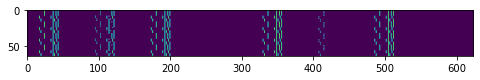

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(sample_song)
plt.show()

Against the generator output

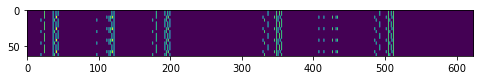

In [ ]:
out = generator(sample_chroma)

plt.figure(figsize=(8, 6))
plt.imshow(out)
plt.show()

In [ ]:
generator.call.get_concrete_function

AttributeError: 'function' object has no attribute 'get_concrete_function'

In [ ]:
out = gen_loaded(sample_chroma)

plt.figure(figsize=(8, 6))
plt.imshow(out)
plt.show()

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * Tensor("inputs:0", shape=(64, 48), dtype=float32)
  Keyword arguments: {}

Expected these arguments to match one of the following 1 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, None, 48), dtype=tf.float32, name='inputs')
  Keyword arguments: {}

Naturally it doesn't make sense to look at this as an image but it at least shows the result is close enough

# Style Transfer

In [ ]:
classical_songs, fpaths = get_songs("../data/chordGan/CLassical_Bach/bachpreludes")
classical_chromas = get_chromas(classical_songs)

C:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
if not os.path.exists("converted/"):
    os.makedirs("converted/")

for idx, (c_chroma, fpath) in enumerate(zip(classical_chromas, fpaths)):
    # reshape
    song_timesteps = c_chroma.shape[0] // n_timesteps
    c_chroma = c_chroma[: song_timesteps * n_timesteps]
    c_chroma = c_chroma.reshape(song_timesteps, c_chroma.shape[1] * n_timesteps)

    converted_song = generator(c_chroma).numpy()
    S = converted_song.reshape(
        int(reduce(lambda x, y: x * y, converted_song.shape) / 2 / note_range),
        2 * note_range,
    )
    S_thresh = (S >= 0.5).T
    C = c_chroma.reshape(c_chroma.shape[0] * n_timesteps, 12)

    output = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(S_thresh), fs=16)
    fname = fpath.split("\\")[-1]
    output.write(f"converted/{fname}.mid")

In [ ]:
S.shape

(652, 156)